In [17]:
from dotenv import load_dotenv
import os
import getpass

load_dotenv()

MODEL_API_KEY= os.environ.get('GOOGLE_API_KEY','-1')
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

# Initialize vision model for image analysis
vision_llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [18]:
import chromadb.utils.embedding_functions as embedding_functions

hg_key = os.environ.get('hugging_face_token', '-1')
huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key=hg_key,
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

Chroma DB connection with local embedding function for cost saving

In [ ]:
import chromadb
  
client = chromadb.CloudClient(
  api_key='ck-7Ns17PwTNfFFSAYDufcAthrTRYiVDWdNfJNnnE2NcVFj',
  tenant='aeec19d2-70b2-444d-9893-b0067678e351',
  database='raggerDB'
)

# Create collections for both documents and chat history
try:
    documents_collection = client.get_collection("documents", embedding_function=huggingface_ef)
    print("Documents collection found")
except:
    documents_collection = client.create_collection("documents", embedding_function=huggingface_ef)
    print("Documents collection created")

try:
    chat_collection = client.get_collection("chat_history", embedding_function=huggingface_ef)
    print("Chat collection found")
except:
    chat_collection = client.create_collection("chat_history", embedding_function=huggingface_ef)
    print("Chat collection created")

In [ ]:

# Create collections for both documents and chat history
documents_collection = client.create_collection("documents", embedding_function=huggingface_ef)
chat_collection = client.create_collection("chat_history", embedding_function=huggingface_ef)

## File processing layer

In [21]:
import util.data_extraction as data_extraction
from util.smart_chunking import SmartDocumentChunker

# Initialize smart chunker
chunker = SmartDocumentChunker(chunk_size=1000, chunk_overlap=200)

# Enhanced file loader function for multi-modal input
def process_file(file_path: str):
    """Process a file using enhanced extraction and smart chunking"""
    try:
        # Extract content with OCR
        text, images, links = data_extraction.extract_content(file_path)
        print(f"Extracted {len(text)} characters, {len(images)} images, {len(links)} links")
        
        # Apply smart chunking
        documents = chunker.chunk_document(text, file_path, images, links)
        print(f"Created {len(documents)} chunks")
        
        return documents
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return []

# Example usage (commented out until we have actual files)
# docs = process_file("path/to/your/document.pdf")

### Chat management layer

In [22]:
import uuid
import json
from datetime import datetime
from typing import Dict, List, Optional

class ChatHistoryManager:
    def __init__(self, chat_collection, llm):
        self.chat_collection = chat_collection
        self.llm = llm
    
    def store_conversation(self, session_id: str, user_message: str, ai_response: str, 
                          context_sources: List[str] = None) -> str:
        """Store a conversation turn in the chat history collection"""
        conversation_id = str(uuid.uuid4())
        timestamp = datetime.now().isoformat()
        
        # Create a conversation summary for better searchability
        conversation_text = f"User: {user_message}\nAI: {ai_response}"
        
        # Generate a label for this conversation using LLM
        label = self._generate_conversation_label(user_message, ai_response)
        #** no need to make label on each message. Do it when chat ends
        metadata = {
            "session_id": session_id,
            "conversation_id": conversation_id,
            "timestamp": timestamp,
            "user_message": user_message,
            "ai_response": ai_response,
            "context_sources": context_sources or [],
            "label": label,
            "message_type": "conversation_turn"
        }
        
        self.chat_collection.add(
            documents=[conversation_text],
            metadatas=[metadata],
            ids=[conversation_id]
        )
        
        return conversation_id
    
    def store_session_summary(self, session_id: str, messages: List[Dict]) -> str:
        """Store a summarized version of a long conversation session"""
        summary_id = str(uuid.uuid4())
        timestamp = datetime.now().isoformat()
        
        # Generate conversation summary
        conversation_text = "\n".join([
            f"{'User' if msg.get('role') == 'user' else 'AI'}: {msg.get('content', '')}" 
            for msg in messages
        ])
        
        summary = self._generate_conversation_summary(conversation_text)
        label = self._generate_conversation_label(conversation_text[:500], summary)
        
        metadata = {
            "session_id": session_id,
            "summary_id": summary_id,
            "timestamp": timestamp,
            "message_count": len(messages),
            "original_length": len(conversation_text),
            "summary_length": len(summary),
            "label": label,
            "message_type": "session_summary"
        }
        
        self.chat_collection.add(
            documents=[summary],
            metadatas=[metadata],
            ids=[summary_id]
        )
        
        return summary_id
    
    def search_chat_history(self, query: str, session_id: Optional[str] = None, 
                           limit: int = 5) -> List[Dict]:
        """Search through chat history for relevant conversations"""
        where_filter = {"message_type": {"$in": ["conversation_turn", "session_summary"]}}
        
        if session_id:
            where_filter["session_id"] = session_id
        
        results = self.chat_collection.query(
            query_texts=[query],
            n_results=limit,
            where=where_filter
        )
        
        return self._format_chat_results(results)
    
    def get_session_context(self, session_id: str, limit: int = 10) -> List[Dict]:
        """Get recent conversation context for a specific session"""
        results = self.chat_collection.query(
            query_texts=[""],  # Empty query to get by metadata only
            n_results=limit,
            where={"session_id": session_id, "message_type": "conversation_turn"}
        )
        
        return self._format_chat_results(results)
    
    def _generate_conversation_label(self, user_message: str, ai_response: str) -> str:
        """Generate a descriptive label for the conversation using LLM"""
        prompt = f"""Generate a short, descriptive label (3-5 words) for this conversation:

User: {user_message[:200]}...
AI: {ai_response[:200]}...

Label:"""
        
        try:
            response = self.llm.invoke(prompt)
            return response.content.strip().replace('\n', ' ')[:50]
        except Exception as e:
            print(f"Error generating label: {e}")
            return "General conversation"
    
    def _generate_conversation_summary(self, conversation_text: str) -> str:
        """Generate a summary of a long conversation"""
        prompt = f"""Summarize this conversation in 2-3 sentences, focusing on the main topics and key information discussed:

{conversation_text[:2000]}...

Summary:"""
        
        try:
            response = self.llm.invoke(prompt)
            return response.content.strip()
        except Exception as e:
            print(f"Error generating summary: {e}")
            return conversation_text[:500] + "..."
    
    def _format_chat_results(self, results: Dict) -> List[Dict]:
        """Format ChromaDB results into a more usable format"""
        formatted_results = []
        
        if results['documents'] and len(results['documents']) > 0:
            for i in range(len(results['documents'][0])):
                formatted_results.append({
                    'content': results['documents'][0][i],
                    'metadata': results['metadatas'][0][i],
                    'distance': results['distances'][0][i] if 'distances' in results else None
                })
        
        return formatted_results

# Initialize chat history manager
chat_manager = ChatHistoryManager(chat_collection, llm)

## Image processing layer

In [23]:
import base64
from langchain_core.messages import HumanMessage

class VisionProcessor:
    def __init__(self, vision_model):
        self.vision_model = vision_model
    
    def analyze_image(self, image_path: str) -> str:
        """Analyze an image using Gemini 2.5 vision capabilities"""
        try:
            # Read and encode image
            with open(image_path, "rb") as image_file:
                image_data = base64.b64encode(image_file.read()).decode()
            
            # Create message with image
            message = HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": "Analyze this image and provide a detailed description. Include any text, objects, charts, diagrams, or other relevant information you can see."
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_data}"
                        }
                    }
                ]
            )
            
            response = self.vision_model.invoke([message])
            return response.content
            
        except Exception as e:
            print(f"Error analyzing image {image_path}: {e}")
            return f"Error analyzing image: {e}"
    
    def analyze_image_bytes(self, image_bytes: bytes, image_name: str = "image") -> str:
        """Analyze image from bytes using Gemini 2.5 vision capabilities"""
        try:
            # Encode image bytes
            image_data = base64.b64encode(image_bytes).decode()
            
            # Create message with image
            message = HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": "Analyze this image and provide a detailed description. Include any text, objects, charts, diagrams, or other relevant information you can see."
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_data}"
                        }
                    }
                ]
            )
            
            response = self.vision_model.invoke([message])
            return response.content
            
        except Exception as e:
            print(f"Error analyzing image {image_name}: {e}")
            return f"Error analyzing image: {e}"

# Initialize vision processor
vision_processor = VisionProcessor(vision_llm)

### Text chunking layer

In [24]:
os.environ.get('USER_AGENT','-1')
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


### Defining Prompt and State 

In [25]:
from langchain import hub

prompt = hub.pull('rlm/rag-prompt')

example_message = prompt.invoke( {"context": "(context goes here)", "question": "(question goes here)"}).to_messages()

print(example_message[0].content)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [26]:
from langchain_core.documents import Document
from typing_extensions import TypedDict, List

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    session_id: str  # Added session tracking

### Retrieve and Generate definition

In [ ]:
def retrieve(state: State):
    """Enhanced retrieval from both document and chat collections"""
    question = state.get('question', '')
    
    # Debug: Check if question is valid
    if not question or not question.strip():
        print(f"Warning: Empty question received: '{question}'")
        return {'context': []}
    
    print(f"Searching for: '{question}'")
    
    # Combine results
    all_context = []
    
    try:
        # Check if documents collection has any data
        doc_count = documents_collection.count()
        print(f"Documents collection has {doc_count} items")
        
        if doc_count > 0:
            # Search documents collection
            doc_results = documents_collection.query(
                query_texts=[question],
                n_results=min(3, doc_count)
            )
            print(f"Document search successful")
            
            # Add document results
            if doc_results['documents'] and len(doc_results['documents']) > 0:
                for i in range(len(doc_results['documents'][0])):
                    from langchain_core.documents import Document
                    all_context.append(Document(
                        page_content=doc_results['documents'][0][i],
                        metadata=doc_results['metadatas'][0][i] if doc_results['metadatas'] and len(doc_results['metadatas']) > 0 else {}
                    ))
        else:
            print("Documents collection is empty")
            
    except Exception as e:
        print(f"Error searching documents: {e}")
    
    try:
        # Check if chat collection has any data
        chat_count = chat_collection.count()
        print(f"Chat collection has {chat_count} items")
        
        if chat_count > 0:
            # Search chat history for relevant context
            chat_results = chat_manager.search_chat_history(question, limit=2)
            print(f"Chat search successful, found {len(chat_results)} results")
            
            # Add chat history results
            for chat_result in chat_results:
                from langchain_core.documents import Document
                all_context.append(Document(
                    page_content=f"Previous conversation: {chat_result['content']}",
                    metadata={"source": "chat_history", **chat_result['metadata']}
                ))
        else:
            print("Chat collection is empty")
            
    except Exception as e:
        print(f"Error searching chat history: {e}")
    
    print(f"Total context documents: {len(all_context)}")
    return {'context': all_context}

def generate(state: State):
    """Enhanced generation with session tracking"""
    docs_content = "\n\n".join(doc.page_content for doc in state['context'])
    
    # If no context available, use a default message
    if not docs_content.strip():
        docs_content = "No relevant context found in knowledge base."
    
    # Create enhanced prompt with context sources
    sources = [doc.metadata.get('source', 'unknown') for doc in state['context']]
    context_info = f"Sources: {', '.join(set(sources))}\n\n" if sources else ""
    
    fed_prompt = prompt.invoke({
        'question': state['question'], 
        'context': context_info + docs_content
    })
    
    response = llm.invoke(fed_prompt)
    
    # Store this conversation in chat history
    session_id = state.get('session_id', 'default_session')
    try:
        chat_manager.store_conversation(
            session_id=session_id,
            user_message=state['question'],
            ai_response=response.content,
            context_sources=sources
        )
    except Exception as e:
        print(f"Error storing conversation: {e}")
    
    return {'answer': response.content}

def enhanced_rag_query(question: str, session_id: str = "default_session"):
    """Enhanced RAG query with session tracking"""
    if not question or not question.strip():
        return {'error': 'Question cannot be empty'}
    
    state = {
        'question': question.strip(),
        'session_id': session_id,
        'context': [],
        'answer': ''
    }
    
    print(f"Starting RAG query with: '{question}'")
    
    # Retrieve context
    state.update(retrieve(state))
    
    # Generate response
    state.update(generate(state))
    
    return state

In [39]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

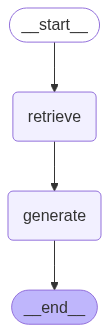

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
# Example usage of enhanced RAG with multimodal support and chat history

# Test enhanced RAG query
result = enhanced_rag_query(question="What is Task Decomposition?", session_id="demo_session_1")

print(f"Question: {result['question']}")
print(f"Session ID: {result['session_id']}")
print(f"Context Sources: {len(result['context'])} documents")
print(f"Answer: {result['answer']}")

# Example of searching chat history
print("\n--- Chat History Search ---")
chat_results = chat_manager.search_chat_history("task decomposition", limit=3)
for i, chat in enumerate(chat_results):
    print(f"Chat {i+1}: {chat['metadata']['label']} - {chat['content'][:100]}...")

# Example file processing (uncomment when you have files to process)
# print("\n--- File Processing Example ---")
# docs = process_file("path/to/your/document.pdf")
# if docs:
#     # Add documents to collection
#     doc_texts = [doc.page_content for doc in docs]
#     doc_metadatas = [doc.metadata for doc in docs]
#     doc_ids = [f"doc_{i}" for i in range(len(docs))]
#     
#     documents_collection.add(
#         documents=doc_texts,
#         metadatas=doc_metadatas,
#         ids=doc_ids
#     )
#     print(f"Added {len(docs)} document chunks to collection")

# Example vision analysis (uncomment when you have images to analyze)
# print("\n--- Vision Analysis Example ---")
# image_analysis = vision_processor.analyze_image("path/to/your/image.jpg")
# print(f"Image Analysis: {image_analysis}")

JSONDecodeError: Expecting value: line 1 column 1 (char 0) in query.